In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
my_data_dir = '/content/drive/MyDrive/FRONTS_AUGMENTED/'

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


class ImageClassifierDataset(Dataset):
    def __init__(self, image_list, image_classes):
        self.images = []
        self.labels = []

        self.classes = list(set(image_classes))
        self.class_to_label = {c: i for i, c in enumerate(self.classes)}
        self.image_size = 240

        self.transforms = transforms.Compose([
            transforms.Resize([self.image_size, self.image_size]),
            #  transforms.CenterCrop(self.image_size), 
              transforms.ToTensor(),
            transforms.Normalize((0.5), (0.5))])

        for image, image_class in zip(image_list, image_classes):
            transformed_image = self.transforms(image)
            self.images.append(transformed_image)
            label = self.class_to_label[image_class]
            self.labels.append(label)


    def __getitem__(self, index):
        return self.images[index], self.labels[index]

    def __len__(self):
        return len(self.images)


In [ ]:
import pathlib
from PIL import Image
from PIL import ImageFile
import torchvision.transforms as T


ImageFile.LOAD_TRUNCATED_IMAGES = True


def load_images(cold, warm, mixed, none):
    images = []
    classes = []
    for path in pathlib.Path(cold).iterdir():
        if path.is_file() and path.suffix == '.png':
            try:
                images.append(Image.open(path).convert('1'))
                classes.append(1)
            except Exception:
                print("could not open image")

    for path in pathlib.Path(warm).iterdir():
        if path.is_file() and path.suffix == '.png':
            try:
                images.append(Image.open(path).convert('1'))
                classes.append(2)
            except Exception:
                print("could not open image")

    for path in pathlib.Path(mixed).iterdir():
        if path.is_file() and path.suffix == '.png':
            try:
                images.append(Image.open(path).convert('1'))
                classes.append(3)
            except Exception:
                print("could not open image")

    for path in pathlib.Path(none).iterdir():
        if path.is_file() and path.suffix == '.png':
            try:
                images.append(Image.open(path).convert('1'))
                classes.append(0)
            except Exception:
                print("could not open image")

    return images, classes


In [ ]:
import torch.nn as nn


class Unit(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=1):
        super(Unit, self).__init__()

        self.conv = nn.Conv2d(in_channels=in_channels, kernel_size=(kernel_size, kernel_size),
                              out_channels=out_channels, padding=padding, stride=stride)
        self.bn = nn.BatchNorm2d(num_features=out_channels)
        self.relu = nn.ReLU()

    def forward(self, input):
        output = self.conv(input)
        output = self.bn(output)
        output = self.relu(output)
        return output


class SimpleNet(nn.Module):
    def __init__(self, num_classes=4):
        super(SimpleNet, self).__init__()

        self.unit1 = Unit(in_channels=1, out_channels=32, kernel_size=1, padding=0) #32X240x240
        self.unit2 = Unit(in_channels=32, out_channels=32, kernel_size=1, padding=0) #32x240x240

        self.unit3 = Unit(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1) #64x120x120
        self.unit4 = Unit(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1) #64x60x60

        self.pool1 = nn.MaxPool2d(kernel_size=2) #64x30x30

        self.unit6 = Unit(in_channels=64, out_channels=128, kernel_size=3, padding=1) #128x30x30
        self.unit7 = Unit(in_channels=128, out_channels=128, kernel_size=3, padding=1) #128x30x30

        self.pool2 = nn.MaxPool2d(kernel_size=2) #128x15x15

        self.unit9 = Unit(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1) #256x8x8
        self.unit10 = Unit(in_channels=256, out_channels=512, kernel_size=3, stride=2, padding=2) #512x4x4
 
        self.dropout4 = nn.Dropout2d()
        self.pool3 = nn.MaxPool2d(kernel_size=4) #512x1x1


        # Add all the units into the Sequential layer in exact order
        self.net = nn.Sequential(self.unit1, self.unit2, self.unit3, self.unit4,
                                self.pool1, self.unit6, self.unit7,
                                 self.pool2, self.unit9,  self.unit10,
                                 self.dropout4,
                                 self.pool3,
                                 )

        self.d1 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(in_features=512, out_features=1024) # 1x512 -> 1x1024
        self.r = nn.ReLU()
        self.fc2 = nn.Linear(in_features=1024, out_features=num_classes) # 1x1024 -> 1x4

    def forward(self, input):
        output = self.net(input) #1x512x1x1
        output = output.reshape(output.size(0), -1) # 1x512
        output = self.d1(output)
        output = self.fc1(output)
        output = self.r(output)
        output = self.fc2(output)
        return output # 1x4


training...


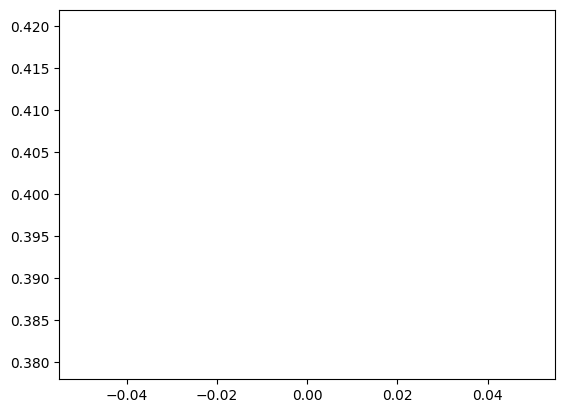

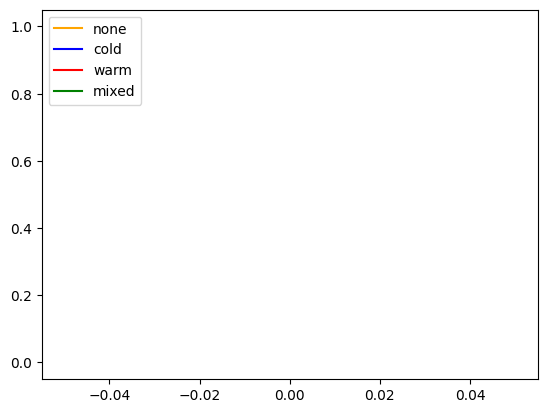

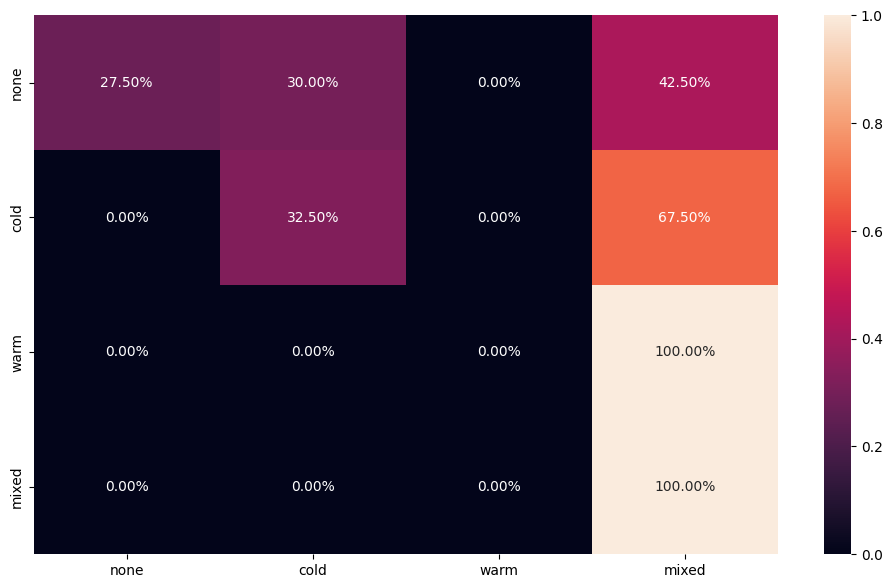

Improved model saved
Epoch 0, Train Accuracy: 0.34166669845581055 , TrainLoss: 1.4747062971194584 , Test Accuracy: 0.4000000059604645
training...


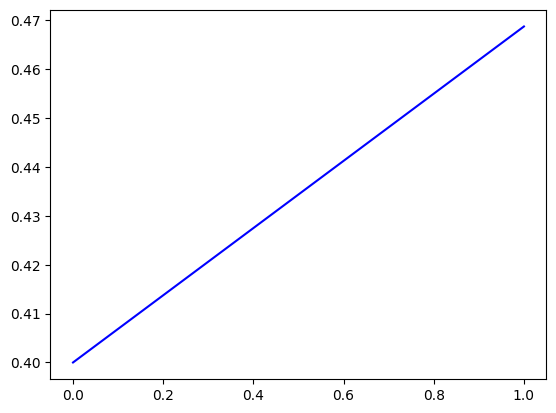

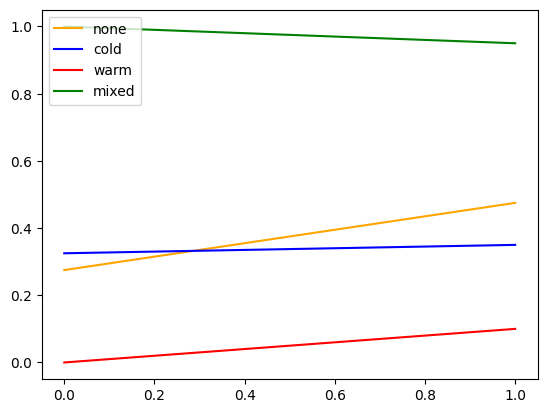

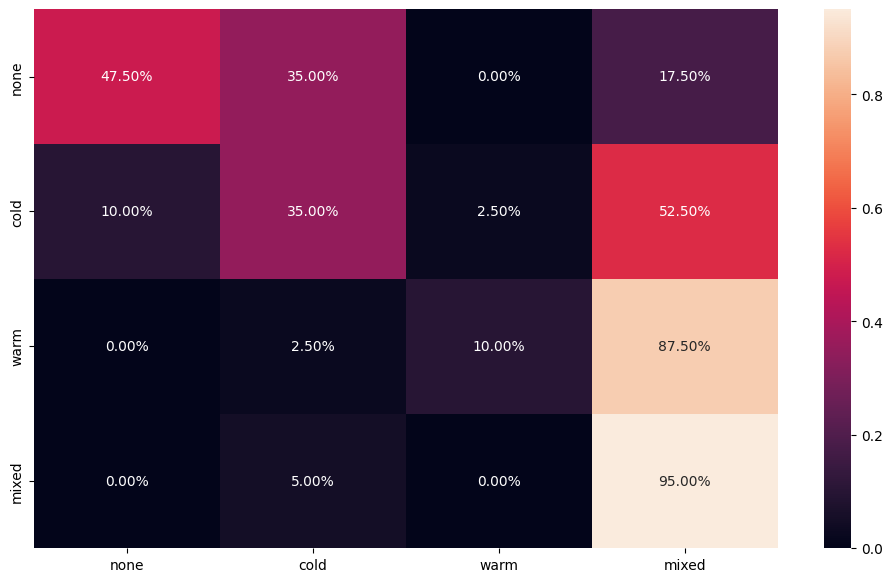

Improved model saved
Epoch 1, Train Accuracy: 0.4520833492279053 , TrainLoss: 1.2630949378013612 , Test Accuracy: 0.46875
training...


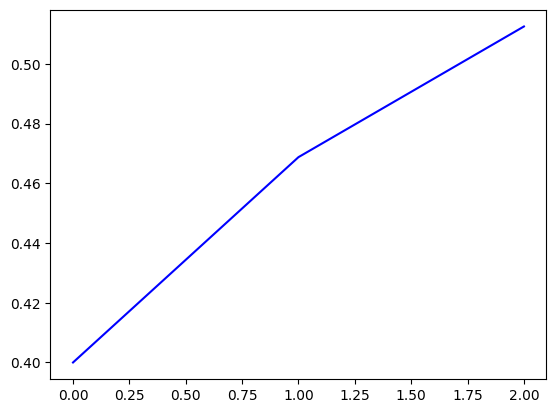

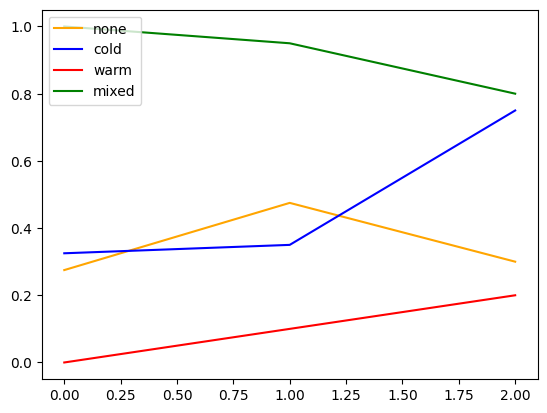

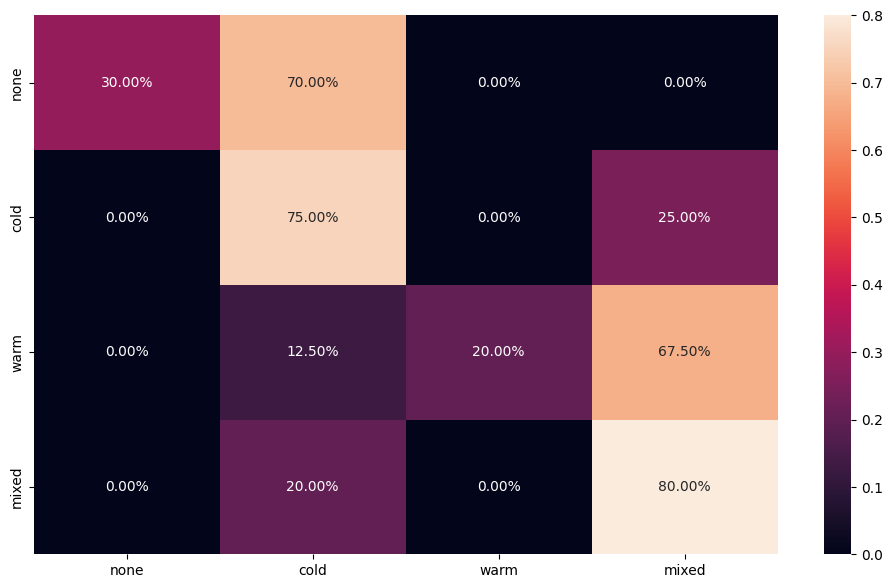

Improved model saved
Epoch 2, Train Accuracy: 0.48750001192092896 , TrainLoss: 1.1625328232844672 , Test Accuracy: 0.512499988079071
training...


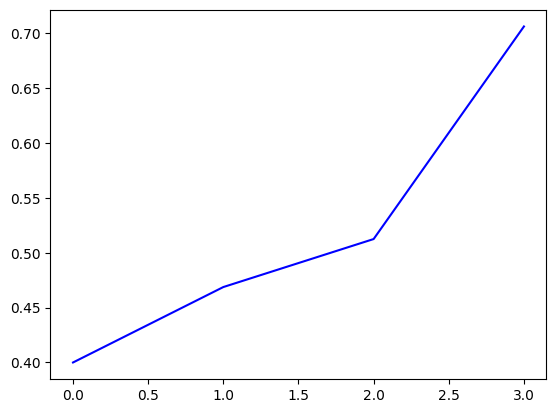

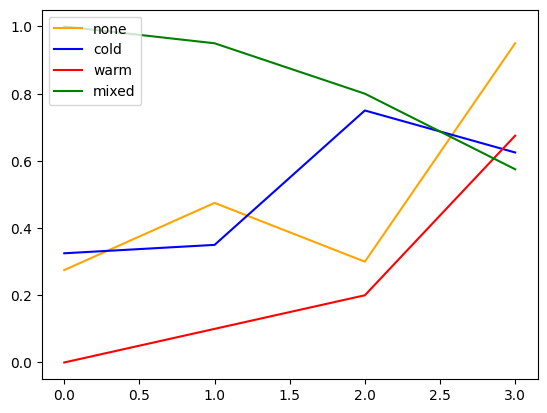

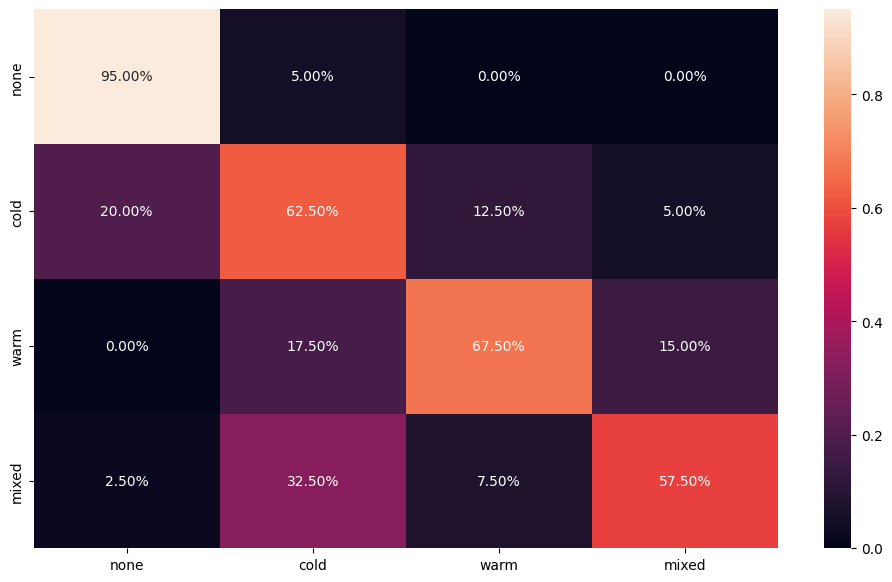

Improved model saved
Epoch 3, Train Accuracy: 0.5333333611488342 , TrainLoss: 1.058210688829422 , Test Accuracy: 0.706250011920929
training...


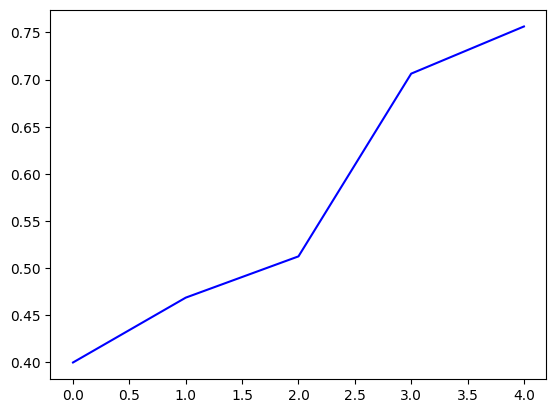

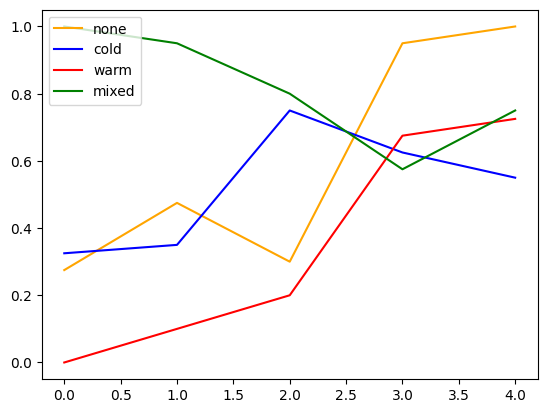

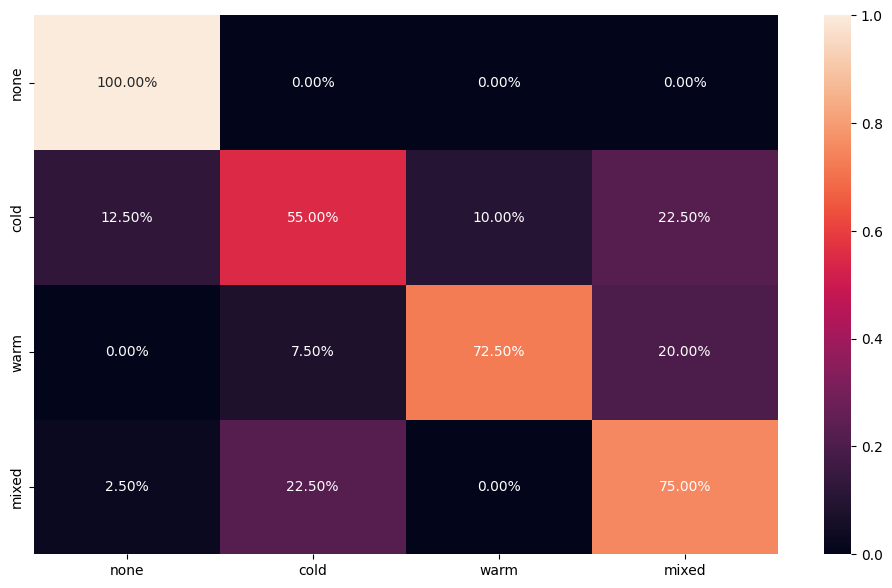

Improved model saved
Epoch 4, Train Accuracy: 0.5875000357627869 , TrainLoss: 1.0051186467210451 , Test Accuracy: 0.7562500238418579
training...
Epoch 5, Train Accuracy: 0.6979166865348816 , TrainLoss: 0.7868414014577866 , Test Accuracy: 0.731249988079071
training...


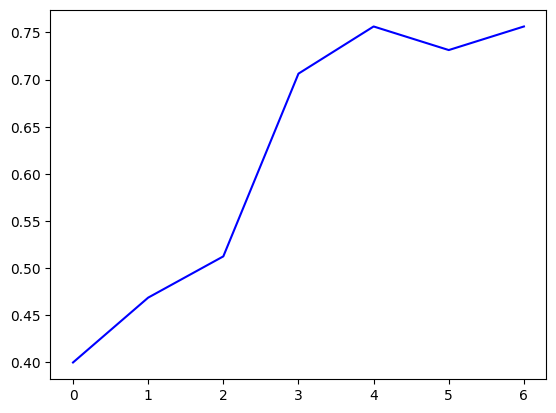

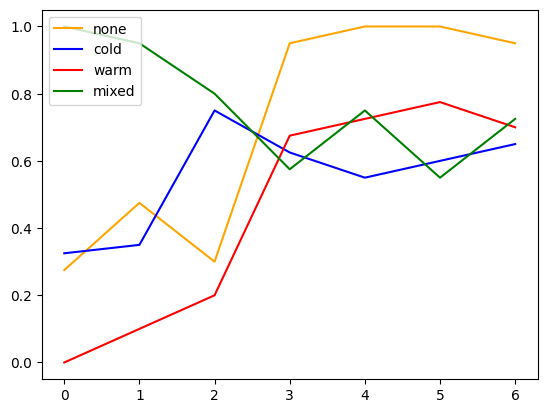

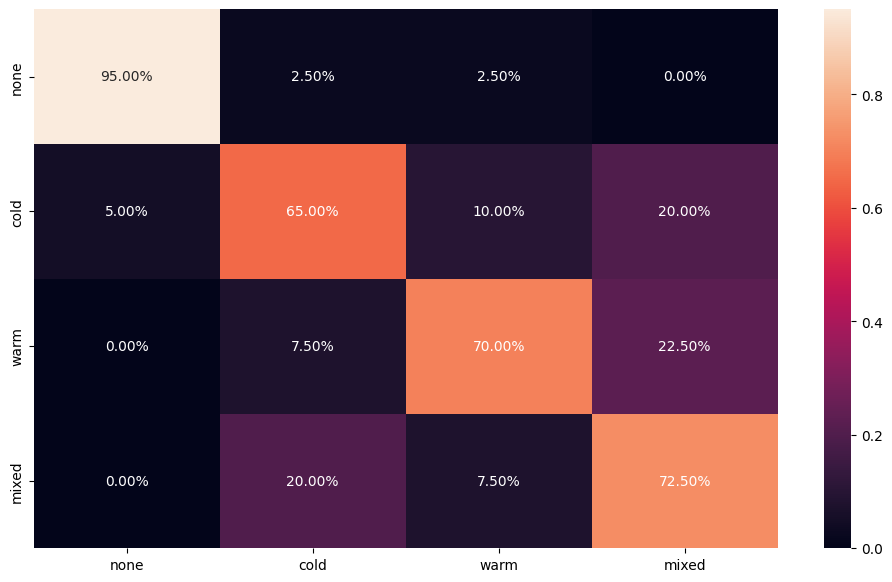

Improved model saved
Epoch 6, Train Accuracy: 0.6854166984558105 , TrainLoss: 0.7686820541818936 , Test Accuracy: 0.7562500238418579
training...


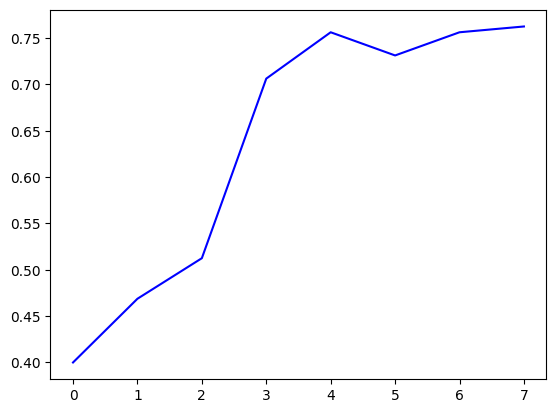

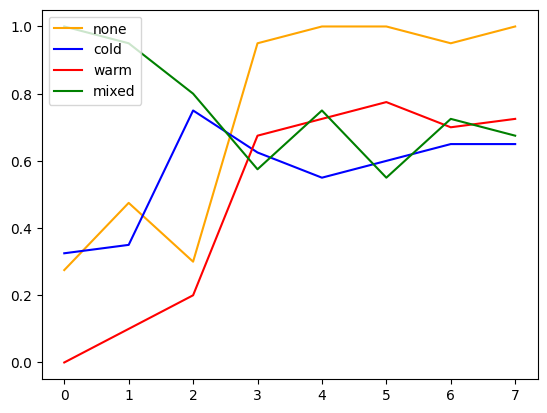

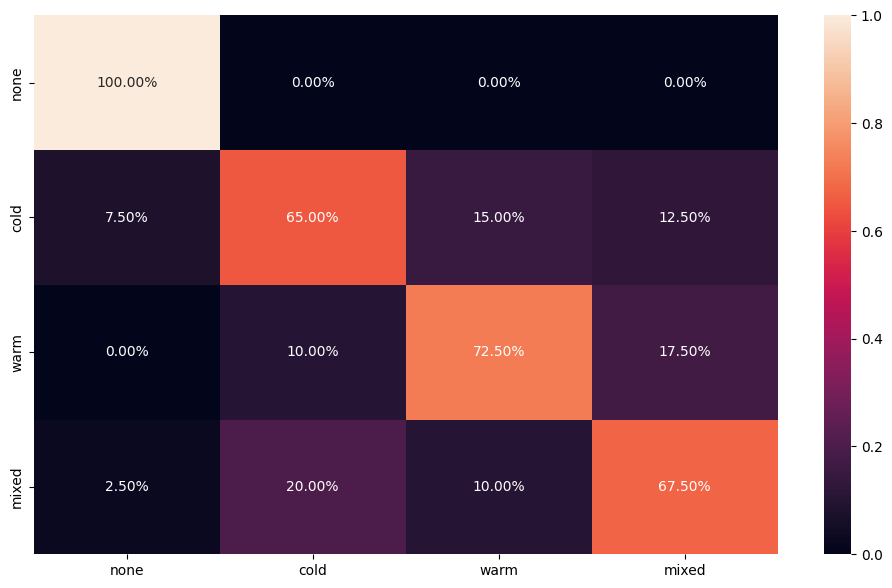

Improved model saved
Epoch 7, Train Accuracy: 0.6916667222976685 , TrainLoss: 0.7368628705541292 , Test Accuracy: 0.762499988079071
training...


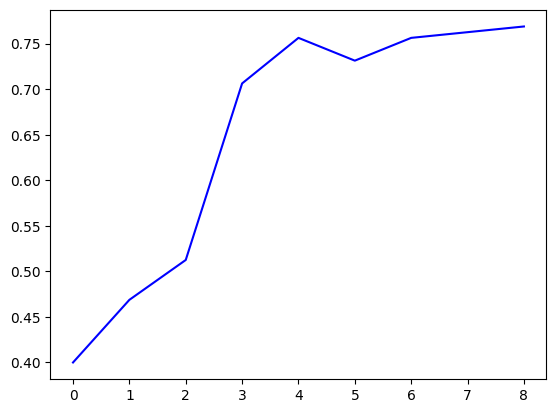

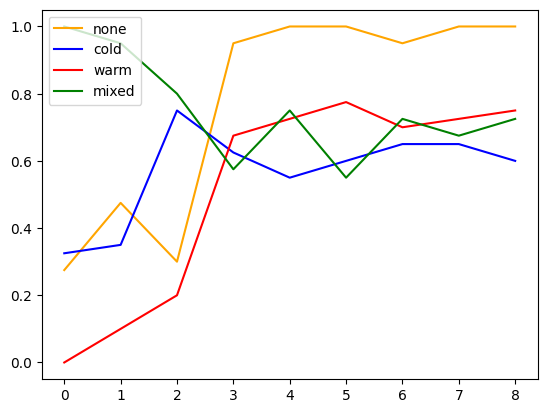

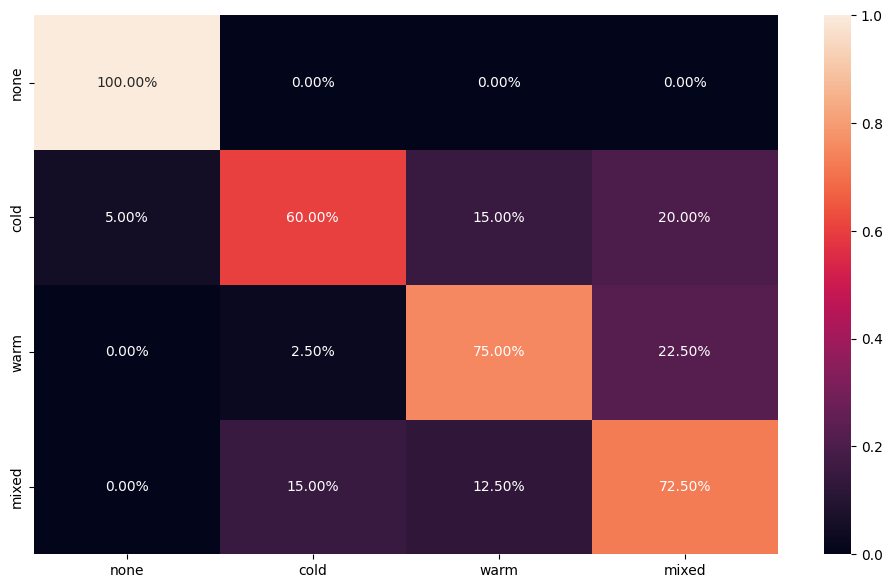

Improved model saved
Epoch 8, Train Accuracy: 0.7458333969116211 , TrainLoss: 0.6989245638251305 , Test Accuracy: 0.768750011920929
training...


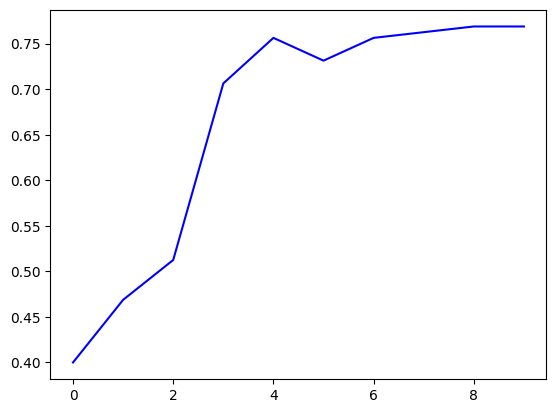

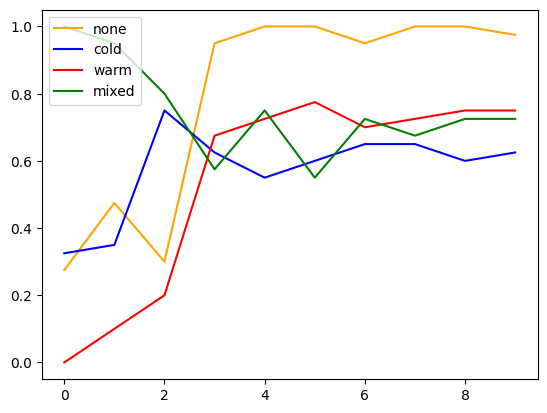

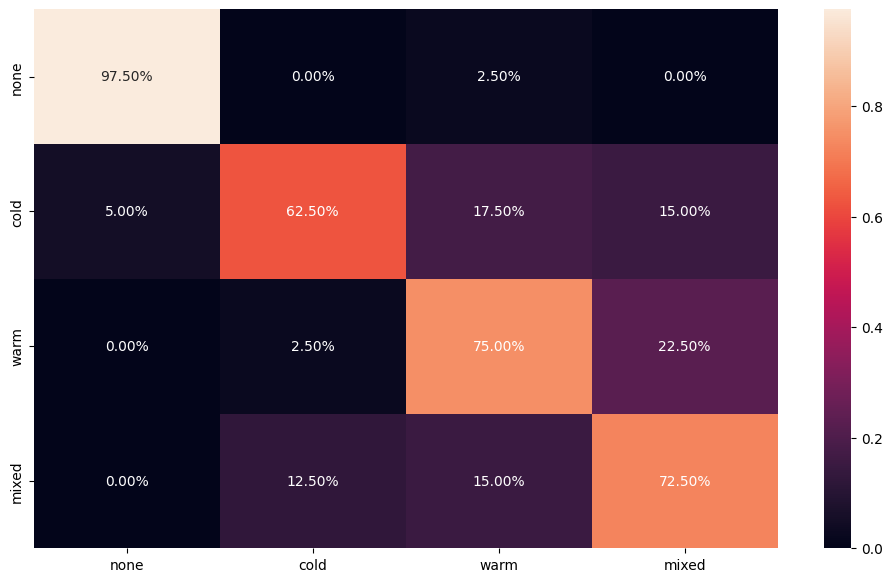

Improved model saved
Epoch 9, Train Accuracy: 0.7187500596046448 , TrainLoss: 0.6882499227921168 , Test Accuracy: 0.768750011920929
training...
Epoch 10, Train Accuracy: 0.737500011920929 , TrainLoss: 0.6418063834309577 , Test Accuracy: 0.7437500357627869
training...
Epoch 11, Train Accuracy: 0.7166666984558105 , TrainLoss: 0.678818496565024 , Test Accuracy: 0.762499988079071
training...


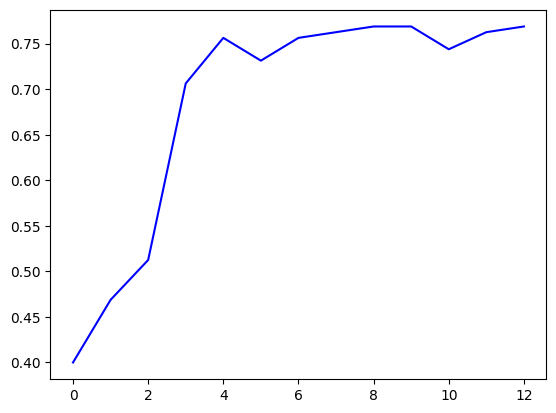

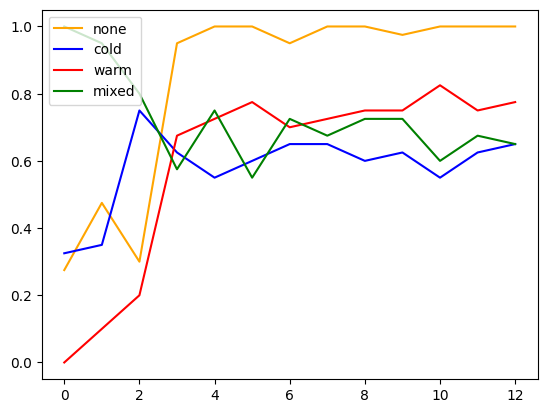

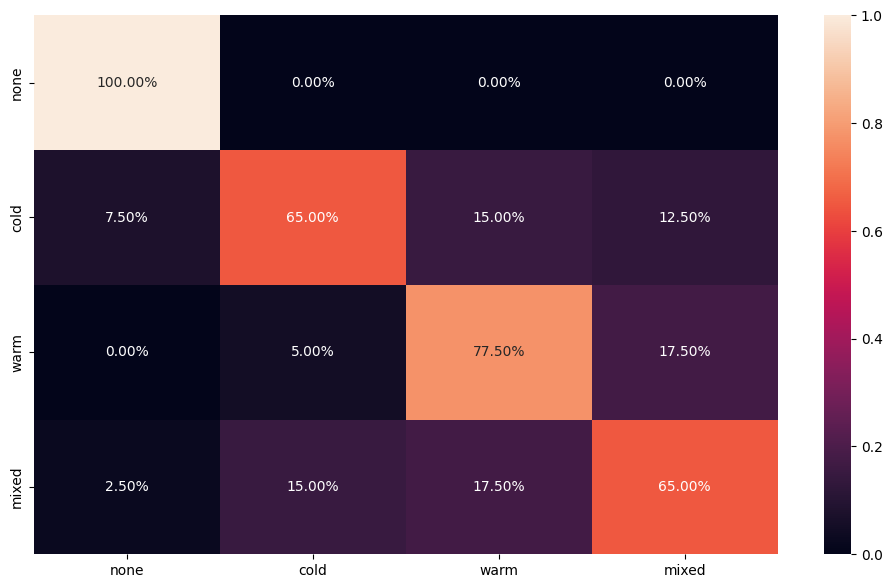

Improved model saved
Epoch 12, Train Accuracy: 0.7312500476837158 , TrainLoss: 0.6931809169550737 , Test Accuracy: 0.768750011920929
training...


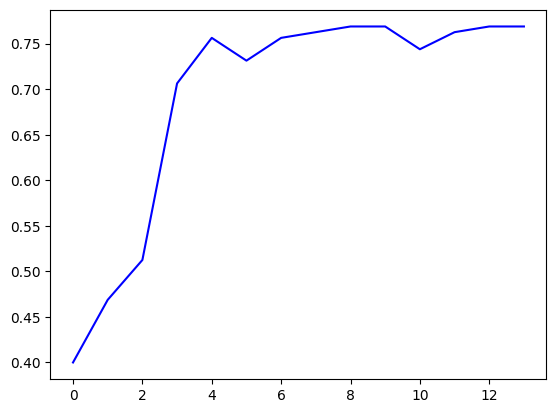

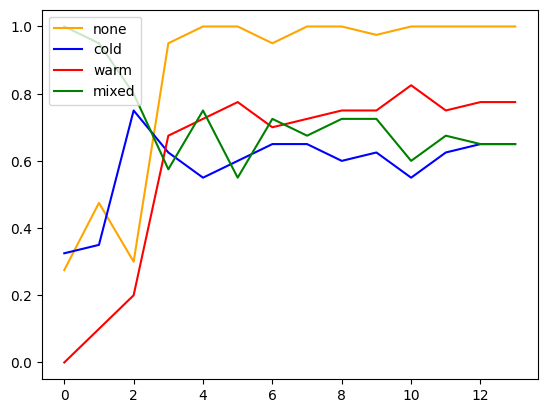

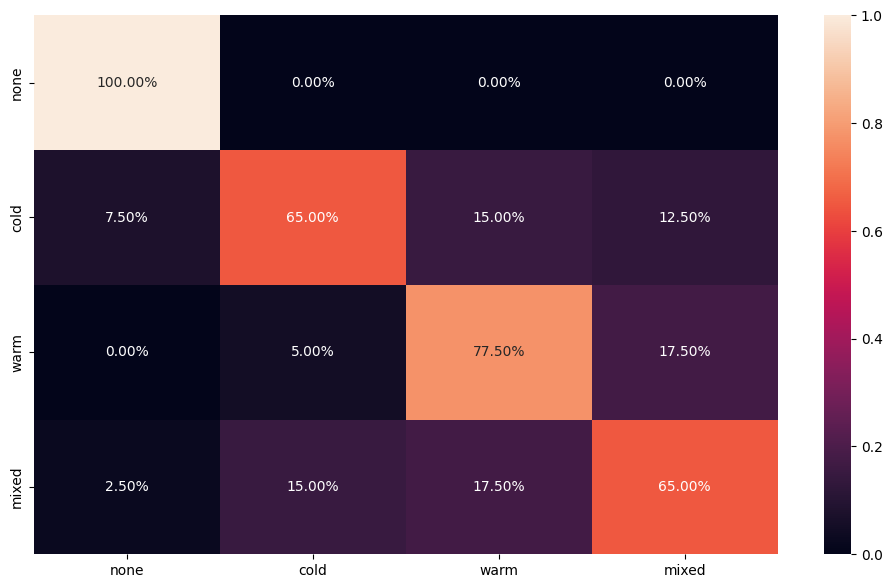

Improved model saved
Epoch 13, Train Accuracy: 0.7541667222976685 , TrainLoss: 0.6290526022513707 , Test Accuracy: 0.768750011920929
training...


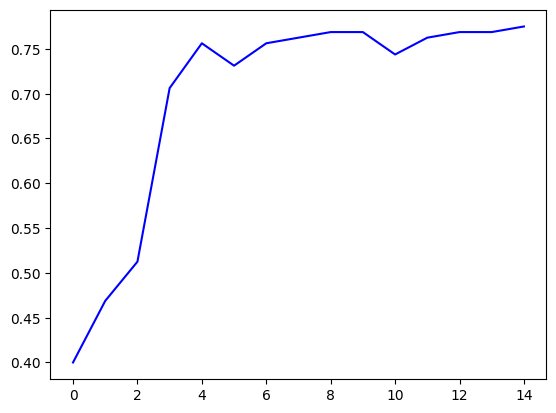

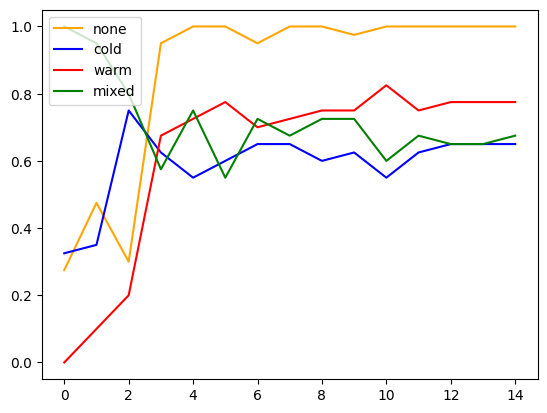

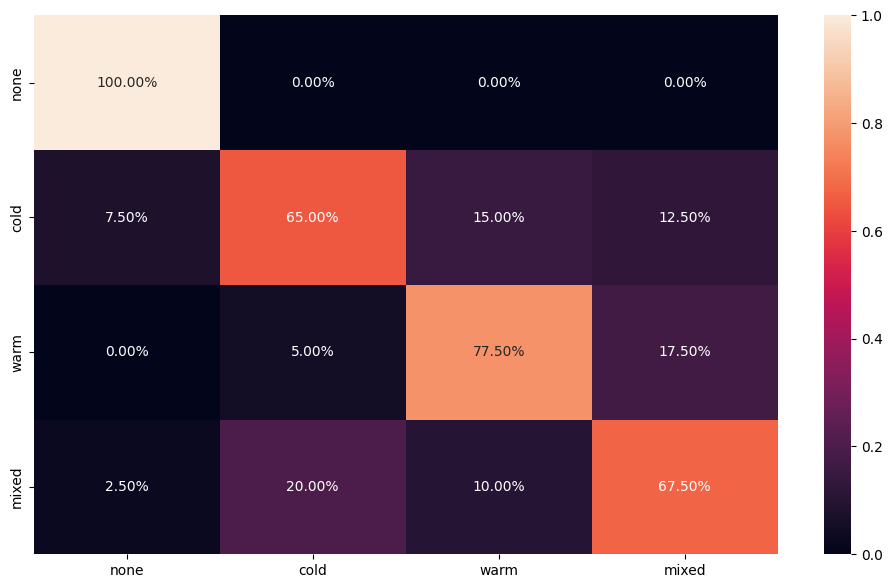

Improved model saved
Epoch 14, Train Accuracy: 0.7625000476837158 , TrainLoss: 0.6316685984532039 , Test Accuracy: 0.7750000357627869
training...
Epoch 15, Train Accuracy: 0.7437500357627869 , TrainLoss: 0.6630334104100863 , Test Accuracy: 0.768750011920929
training...
Epoch 16, Train Accuracy: 0.7187500596046448 , TrainLoss: 0.6963638437290987 , Test Accuracy: 0.762499988079071
training...
Epoch 17, Train Accuracy: 0.7520833611488342 , TrainLoss: 0.6335321113467216 , Test Accuracy: 0.762499988079071
training...
Epoch 18, Train Accuracy: 0.7354167103767395 , TrainLoss: 0.6166111826896667 , Test Accuracy: 0.768750011920929
training...
Epoch 19, Train Accuracy: 0.7250000238418579 , TrainLoss: 0.6806556428472201 , Test Accuracy: 0.7562500238418579
training...
Epoch 20, Train Accuracy: 0.7479166984558105 , TrainLoss: 0.6594646255175273 , Test Accuracy: 0.762499988079071
training...
Epoch 21, Train Accuracy: 0.7562500238418579 , TrainLoss: 0.604386497537295 , Test Accuracy: 0.76249998807907

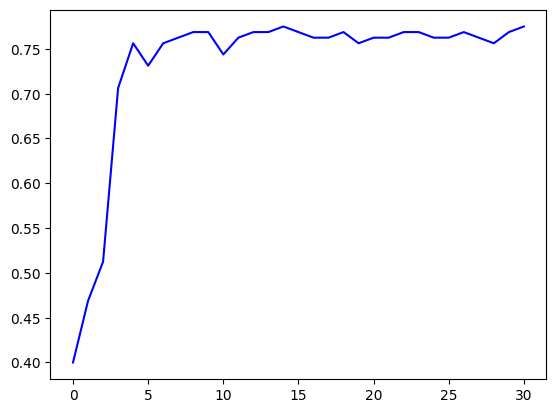

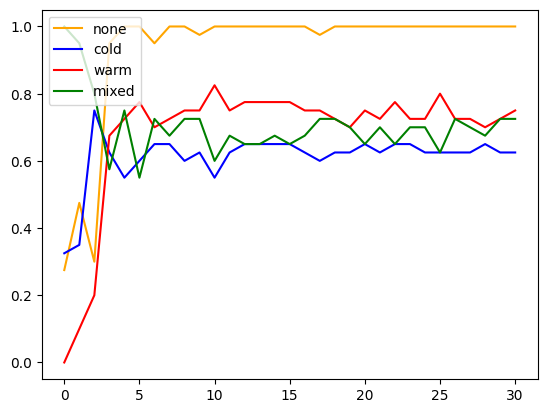

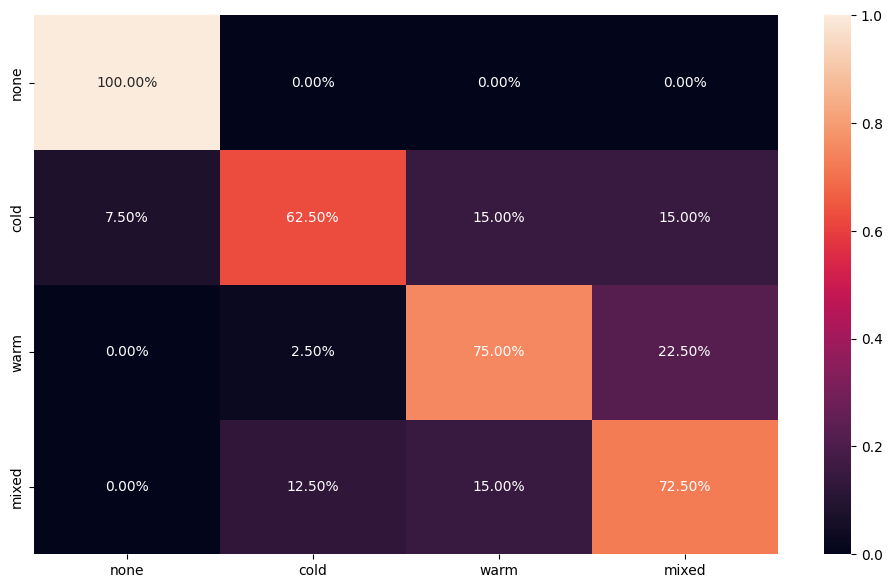

Improved model saved
Epoch 30, Train Accuracy: 0.7395833730697632 , TrainLoss: 0.6362444385886192 , Test Accuracy: 0.7750000357627869
training...
Epoch 31, Train Accuracy: 0.7437500357627869 , TrainLoss: 0.645852550615867 , Test Accuracy: 0.768750011920929
training...
Epoch 32, Train Accuracy: 0.7562500238418579 , TrainLoss: 0.6193315416574479 , Test Accuracy: 0.762499988079071
training...


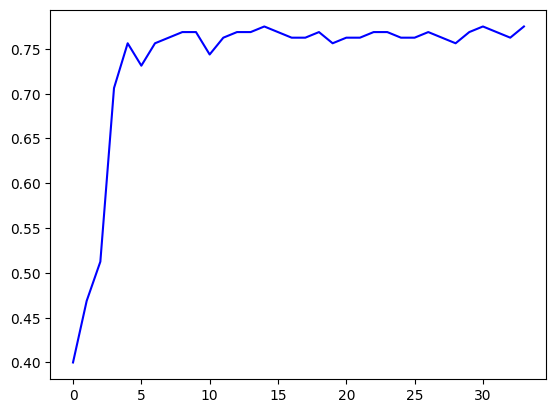

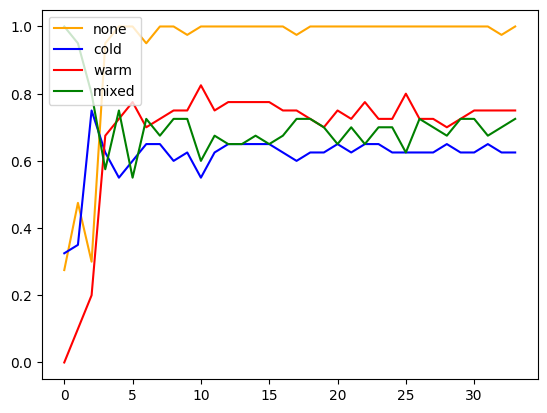

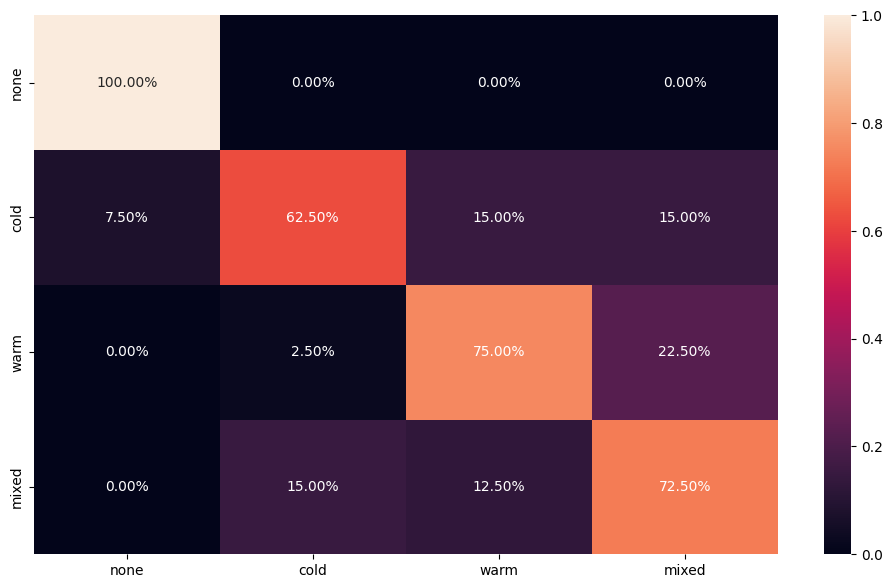

Improved model saved
Epoch 33, Train Accuracy: 0.7270833849906921 , TrainLoss: 0.6926034880181153 , Test Accuracy: 0.7750000357627869
training...
Epoch 34, Train Accuracy: 0.7562500238418579 , TrainLoss: 0.6125388287007809 , Test Accuracy: 0.768750011920929
training...
Epoch 35, Train Accuracy: 0.768750011920929 , TrainLoss: 0.6134897276759148 , Test Accuracy: 0.768750011920929
training...
Epoch 36, Train Accuracy: 0.7270833849906921 , TrainLoss: 0.6880167802174886 , Test Accuracy: 0.768750011920929
training...
Epoch 37, Train Accuracy: 0.7166666984558105 , TrainLoss: 0.6872636745373408 , Test Accuracy: 0.768750011920929
training...
Epoch 38, Train Accuracy: 0.7395833730697632 , TrainLoss: 0.6252267797787984 , Test Accuracy: 0.7562500238418579
training...
Epoch 39, Train Accuracy: 0.7583333849906921 , TrainLoss: 0.612014136215051 , Test Accuracy: 0.768750011920929
training...
Epoch 40, Train Accuracy: 0.7604166865348816 , TrainLoss: 0.6154525289932887 , Test Accuracy: 0.762499988079071

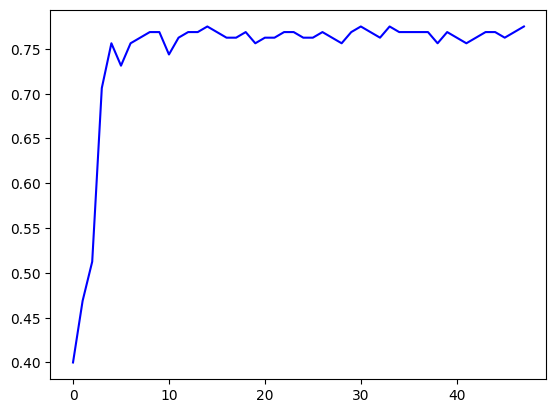

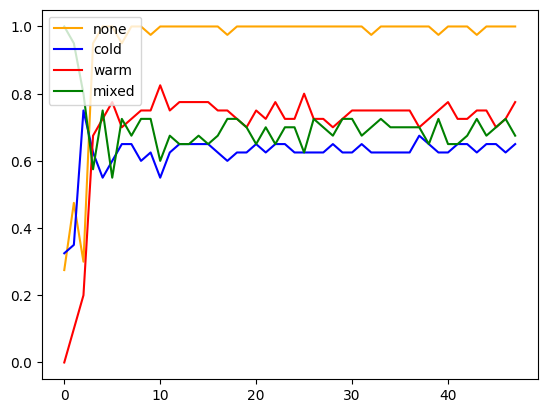

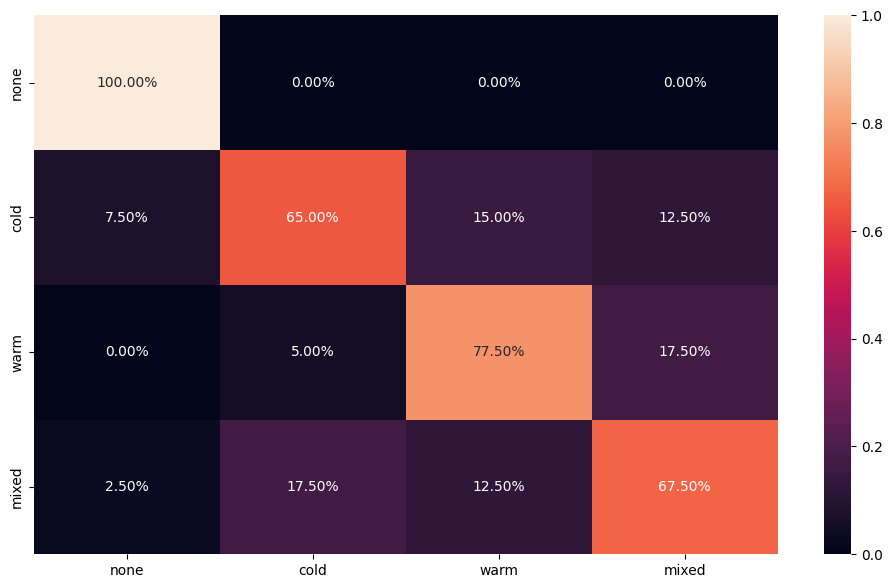

Improved model saved
Epoch 47, Train Accuracy: 0.7750000357627869 , TrainLoss: 0.6061458807438612 , Test Accuracy: 0.7750000357627869
training...
Epoch 48, Train Accuracy: 0.7562500238418579 , TrainLoss: 0.6262120977044106 , Test Accuracy: 0.75
training...
Epoch 49, Train Accuracy: 0.7437500357627869 , TrainLoss: 0.6076990763346354 , Test Accuracy: 0.75
training...
Epoch 50, Train Accuracy: 0.7500000596046448 , TrainLoss: 0.6285122888783614 , Test Accuracy: 0.762499988079071
training...
Epoch 51, Train Accuracy: 0.7625000476837158 , TrainLoss: 0.626981274286906 , Test Accuracy: 0.762499988079071
training...
Epoch 52, Train Accuracy: 0.7708333730697632 , TrainLoss: 0.6393746972084046 , Test Accuracy: 0.762499988079071
training...
Epoch 53, Train Accuracy: 0.7812500596046448 , TrainLoss: 0.5991989071170489 , Test Accuracy: 0.768750011920929
training...


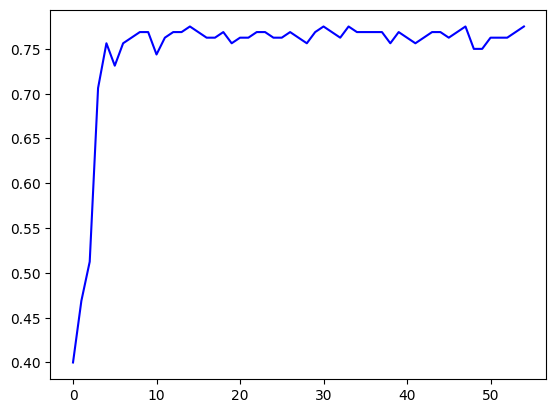

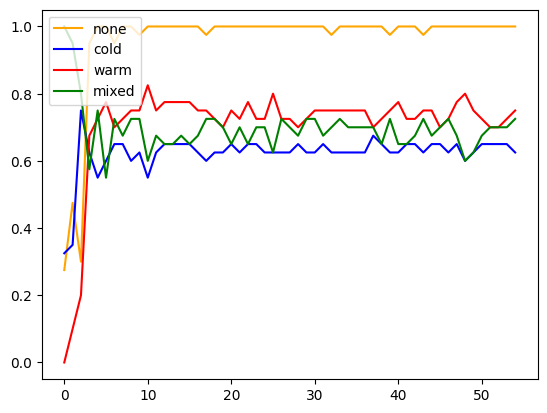

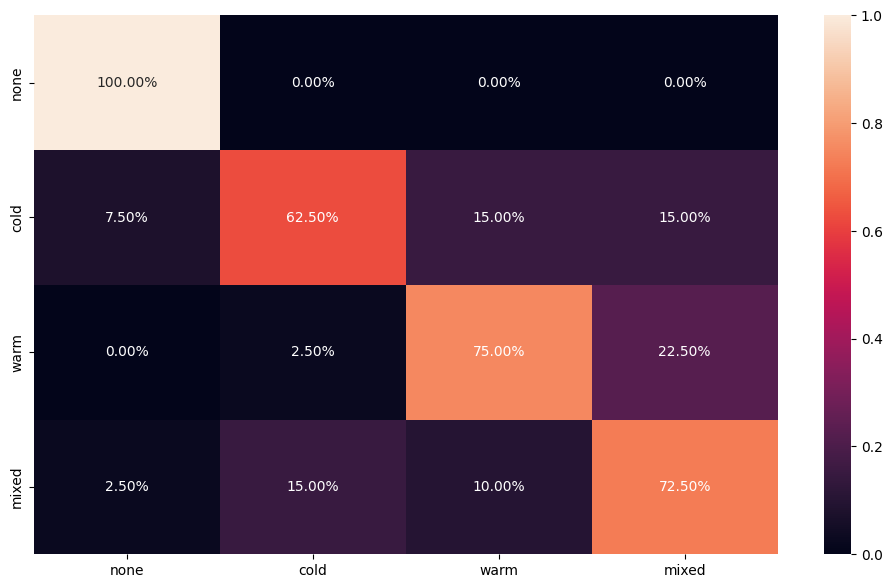

Improved model saved
Epoch 54, Train Accuracy: 0.7354167103767395 , TrainLoss: 0.6618246227502823 , Test Accuracy: 0.7750000357627869
training...
Epoch 55, Train Accuracy: 0.7479166984558105 , TrainLoss: 0.6530006396273772 , Test Accuracy: 0.7562500238418579
training...
Epoch 56, Train Accuracy: 0.7645833492279053 , TrainLoss: 0.6241057184835275 , Test Accuracy: 0.768750011920929
training...
Epoch 57, Train Accuracy: 0.7354167103767395 , TrainLoss: 0.6345571021238963 , Test Accuracy: 0.762499988079071
training...
Epoch 58, Train Accuracy: 0.7708333730697632 , TrainLoss: 0.6137841902673244 , Test Accuracy: 0.768750011920929
training...
Epoch 59, Train Accuracy: 0.737500011920929 , TrainLoss: 0.6799428691466649 , Test Accuracy: 0.768750011920929
training...
Epoch 60, Train Accuracy: 0.7604166865348816 , TrainLoss: 0.6049859409530958 , Test Accuracy: 0.762499988079071
training...
Epoch 61, Train Accuracy: 0.7250000238418579 , TrainLoss: 0.6626412458717823 , Test Accuracy: 0.75625002384185

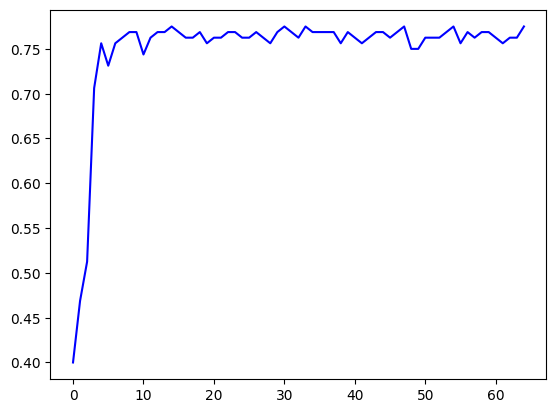

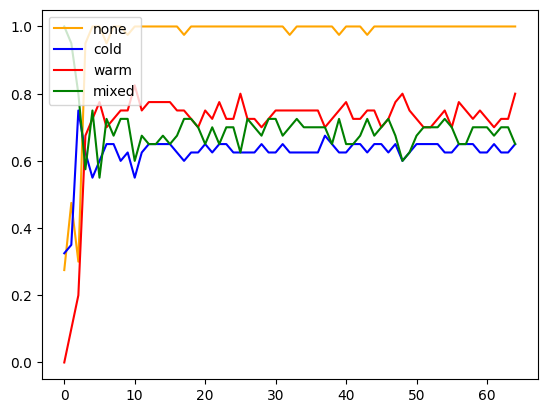

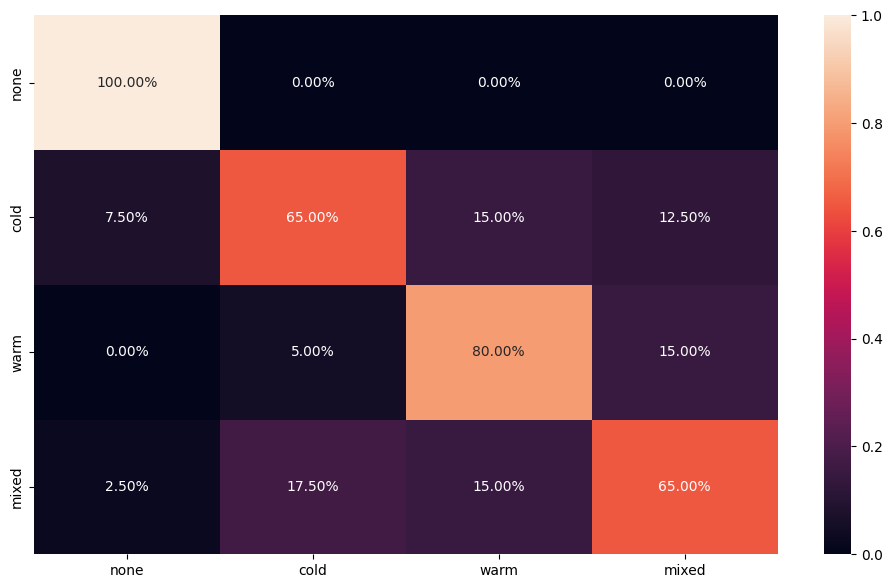

Improved model saved
Epoch 64, Train Accuracy: 0.7625000476837158 , TrainLoss: 0.6389857982595761 , Test Accuracy: 0.7750000357627869
training...
Epoch 65, Train Accuracy: 0.7500000596046448 , TrainLoss: 0.6247726830343405 , Test Accuracy: 0.762499988079071
training...


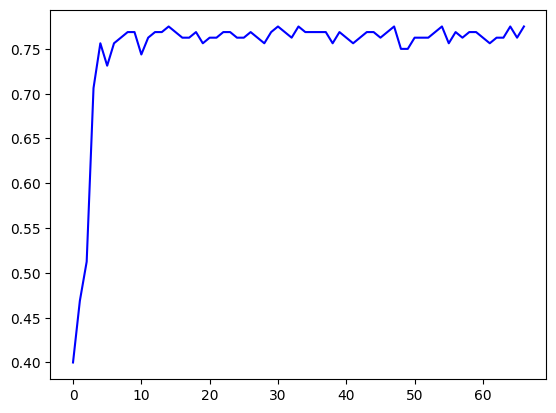

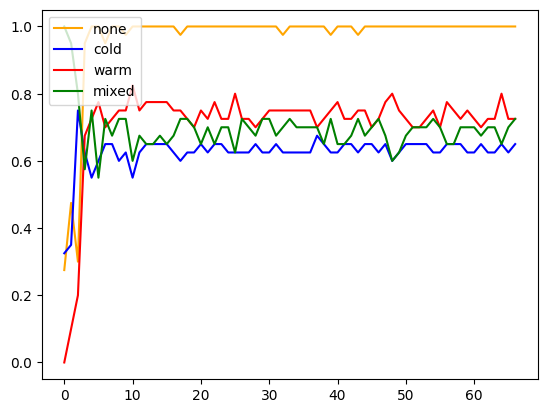

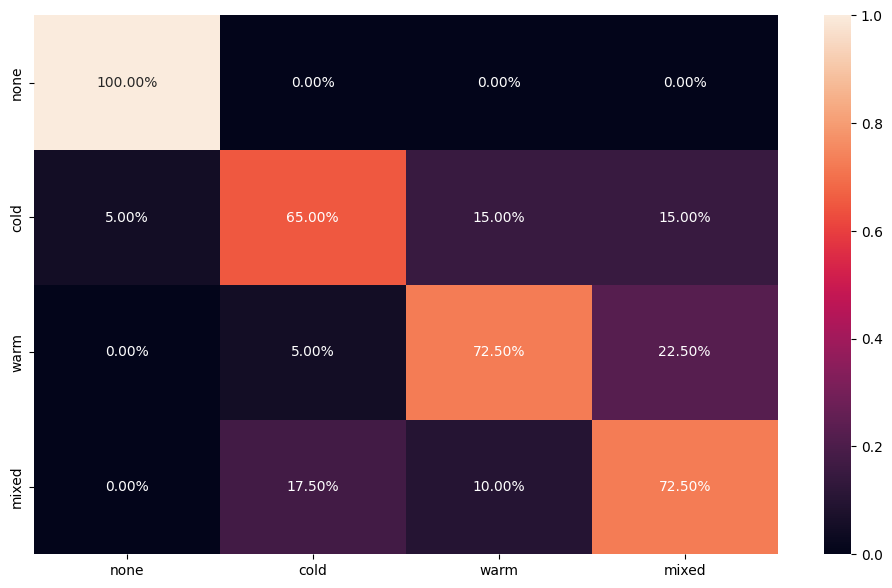

Improved model saved
Epoch 66, Train Accuracy: 0.6854166984558105 , TrainLoss: 0.6899821683764458 , Test Accuracy: 0.7750000357627869
training...
Epoch 67, Train Accuracy: 0.7500000596046448 , TrainLoss: 0.6351838799814383 , Test Accuracy: 0.768750011920929
training...
Epoch 68, Train Accuracy: 0.7291666865348816 , TrainLoss: 0.6548505450288454 , Test Accuracy: 0.768750011920929
training...
Epoch 69, Train Accuracy: 0.737500011920929 , TrainLoss: 0.6523381118973096 , Test Accuracy: 0.768750011920929
training...


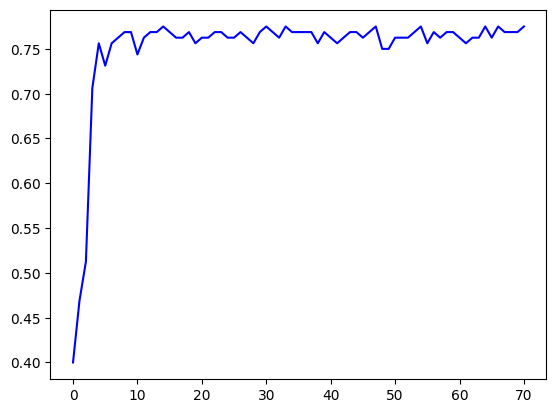

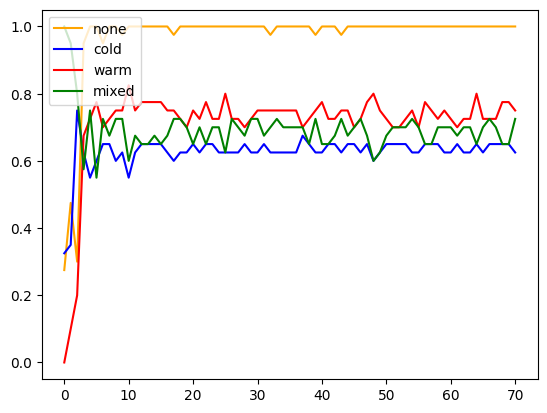

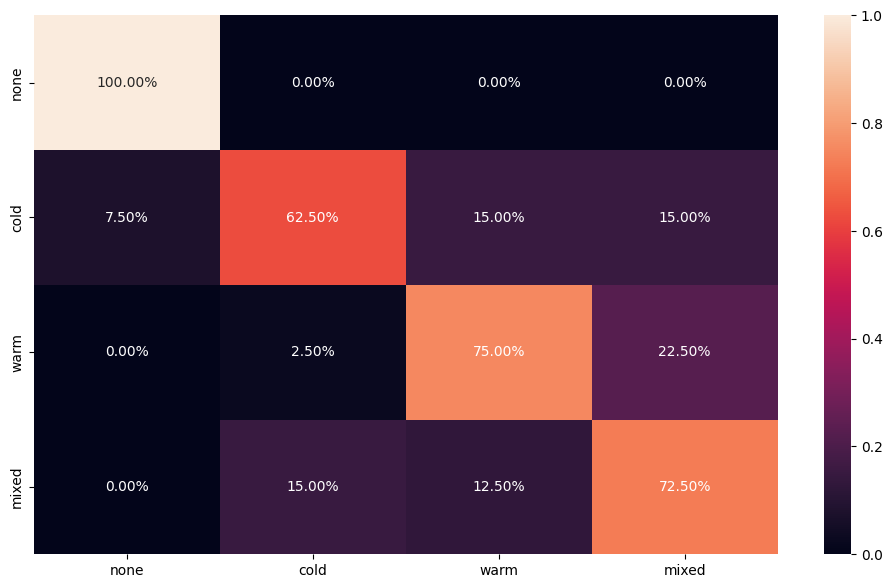

Improved model saved
Epoch 70, Train Accuracy: 0.7270833849906921 , TrainLoss: 0.6758924889067809 , Test Accuracy: 0.7750000357627869
training...
Epoch 71, Train Accuracy: 0.7333333492279053 , TrainLoss: 0.685566616555055 , Test Accuracy: 0.768750011920929
training...
Epoch 72, Train Accuracy: 0.737500011920929 , TrainLoss: 0.650168742487828 , Test Accuracy: 0.762499988079071
training...
Epoch 73, Train Accuracy: 0.7791666984558105 , TrainLoss: 0.6007036082446575 , Test Accuracy: 0.762499988079071
training...
Epoch 74, Train Accuracy: 0.7541667222976685 , TrainLoss: 0.6305521602431933 , Test Accuracy: 0.762499988079071
training...
Epoch 75, Train Accuracy: 0.737500011920929 , TrainLoss: 0.700997352351745 , Test Accuracy: 0.762499988079071
training...
Epoch 76, Train Accuracy: 0.7562500238418579 , TrainLoss: 0.6557288870215416 , Test Accuracy: 0.768750011920929
training...
Epoch 77, Train Accuracy: 0.7604166865348816 , TrainLoss: 0.6396566723783811 , Test Accuracy: 0.7562500238418579
tr

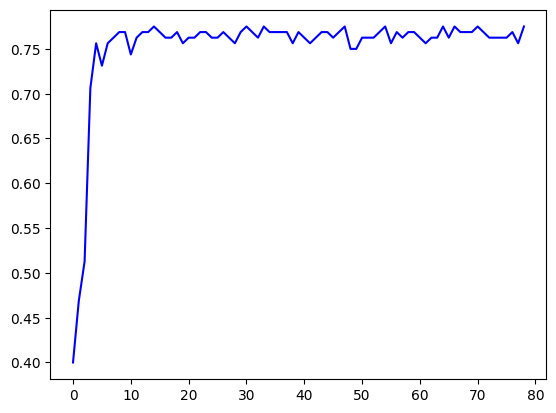

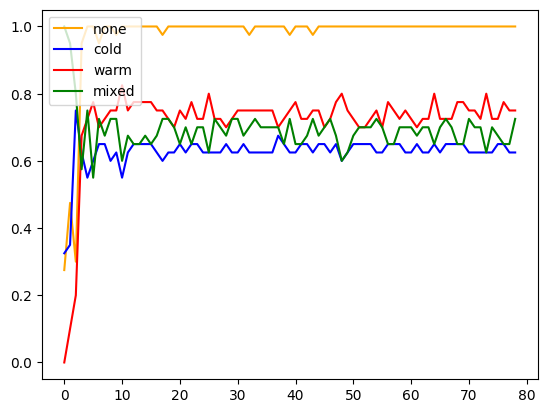

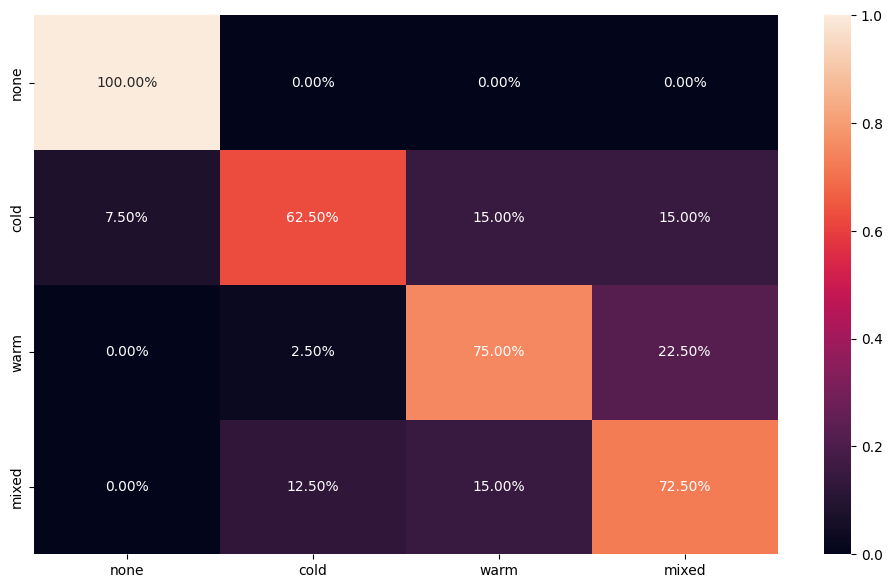

Improved model saved
Epoch 78, Train Accuracy: 0.7583333849906921 , TrainLoss: 0.6105804746349652 , Test Accuracy: 0.7750000357627869
training...
Epoch 79, Train Accuracy: 0.7250000238418579 , TrainLoss: 0.6450681135058403 , Test Accuracy: 0.762499988079071
training...
Epoch 80, Train Accuracy: 0.7437500357627869 , TrainLoss: 0.6168800178915262 , Test Accuracy: 0.768750011920929
training...
Epoch 81, Train Accuracy: 0.7395833730697632 , TrainLoss: 0.6404694338639577 , Test Accuracy: 0.768750011920929
training...


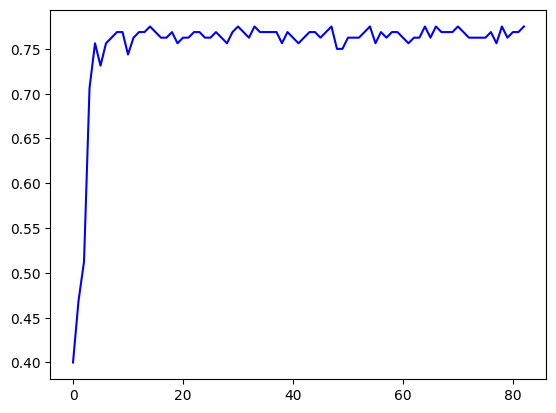

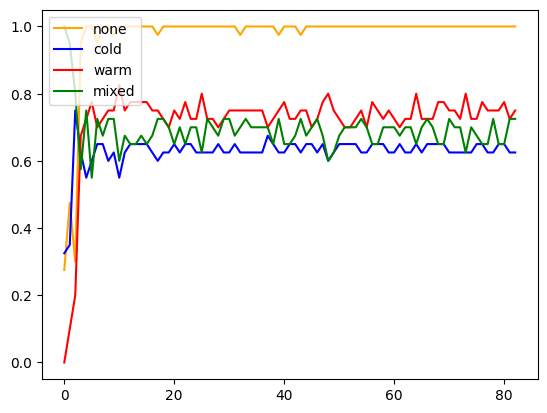

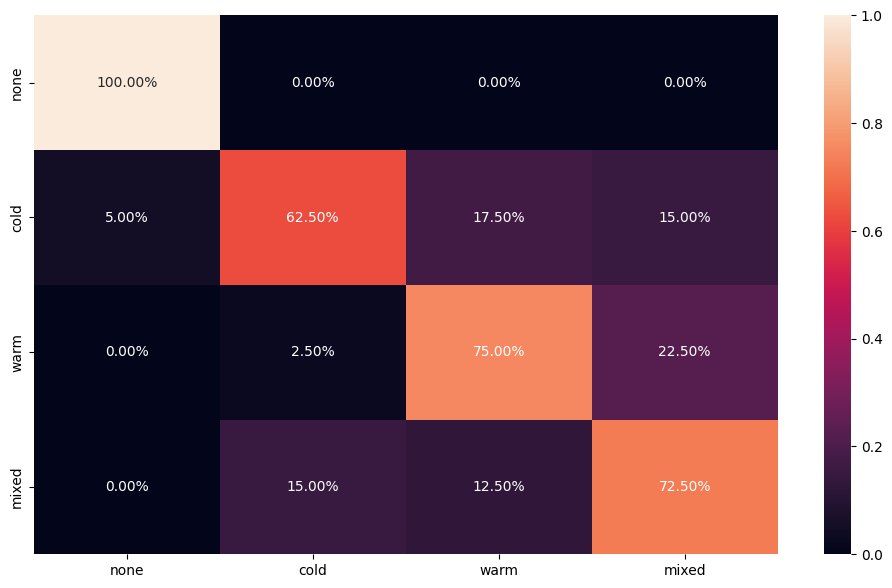

Improved model saved
Epoch 82, Train Accuracy: 0.7500000596046448 , TrainLoss: 0.6291229652861754 , Test Accuracy: 0.7750000357627869
training...
Epoch 83, Train Accuracy: 0.768750011920929 , TrainLoss: 0.6121217054625352 , Test Accuracy: 0.762499988079071
training...
Epoch 84, Train Accuracy: 0.737500011920929 , TrainLoss: 0.6274090610444546 , Test Accuracy: 0.768750011920929
training...


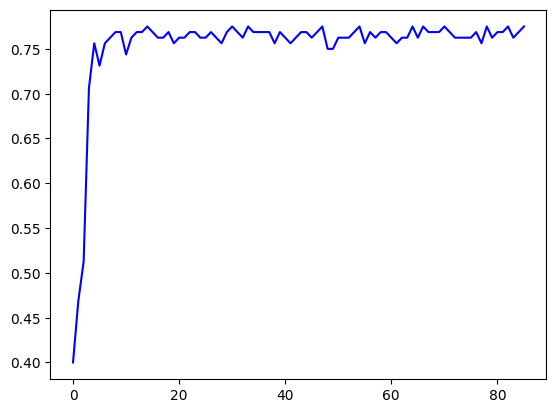

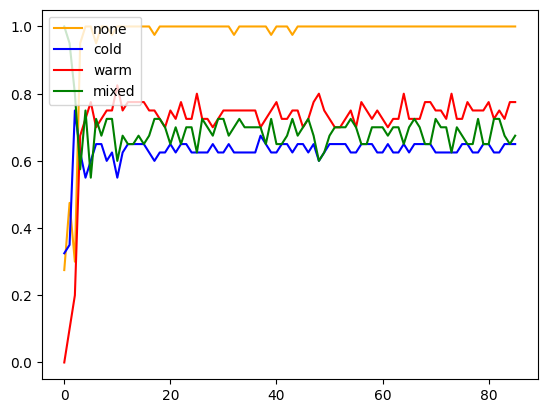

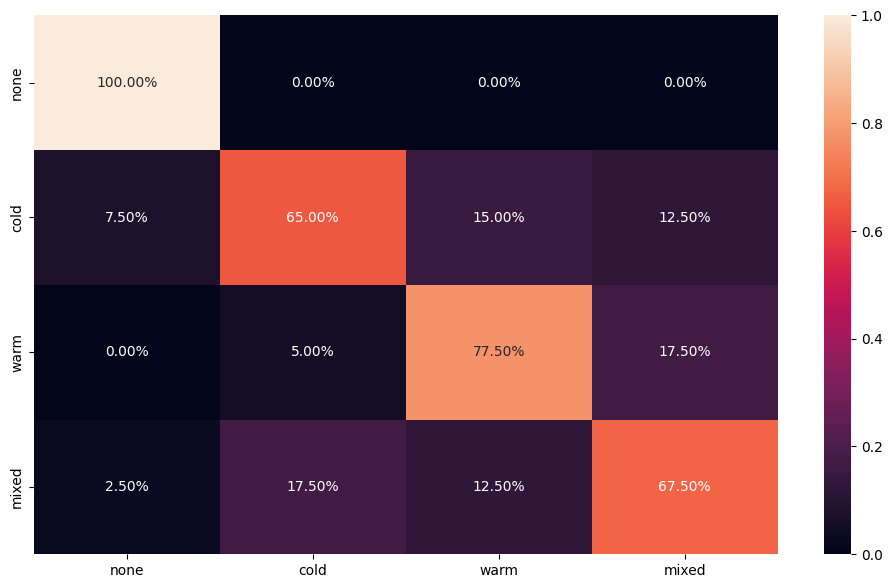

Improved model saved
Epoch 85, Train Accuracy: 0.7479166984558105 , TrainLoss: 0.6302644367019336 , Test Accuracy: 0.7750000357627869
training...
Epoch 86, Train Accuracy: 0.7395833730697632 , TrainLoss: 0.6983560028175513 , Test Accuracy: 0.762499988079071
training...
Epoch 87, Train Accuracy: 0.7708333730697632 , TrainLoss: 0.5826508849859238 , Test Accuracy: 0.768750011920929
training...
Epoch 88, Train Accuracy: 0.7791666984558105 , TrainLoss: 0.5955962573488554 , Test Accuracy: 0.768750011920929
training...
Epoch 89, Train Accuracy: 0.7208333611488342 , TrainLoss: 0.638458476960659 , Test Accuracy: 0.762499988079071
training...
Epoch 90, Train Accuracy: 0.7583333849906921 , TrainLoss: 0.6059136942029 , Test Accuracy: 0.762499988079071
training...
Epoch 91, Train Accuracy: 0.7479166984558105 , TrainLoss: 0.6367956106861432 , Test Accuracy: 0.768750011920929
training...
Epoch 92, Train Accuracy: 0.7645833492279053 , TrainLoss: 0.6060865035901467 , Test Accuracy: 0.768750011920929
tr

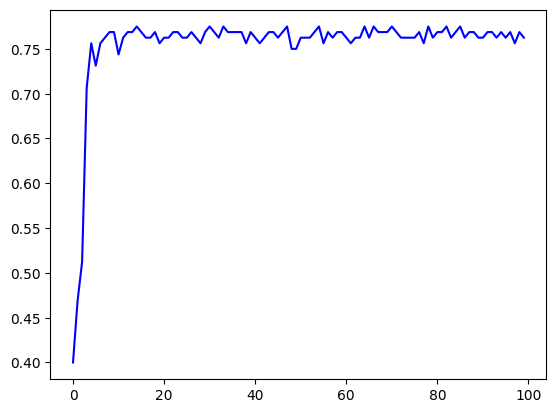

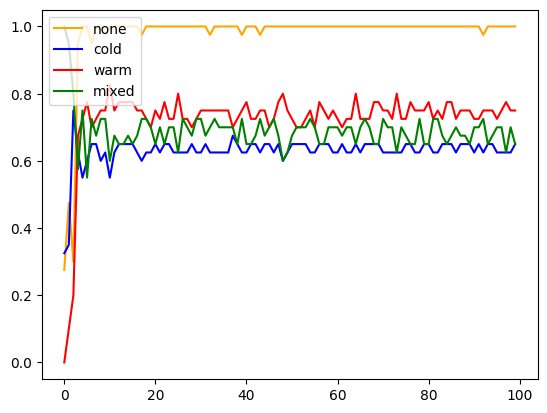

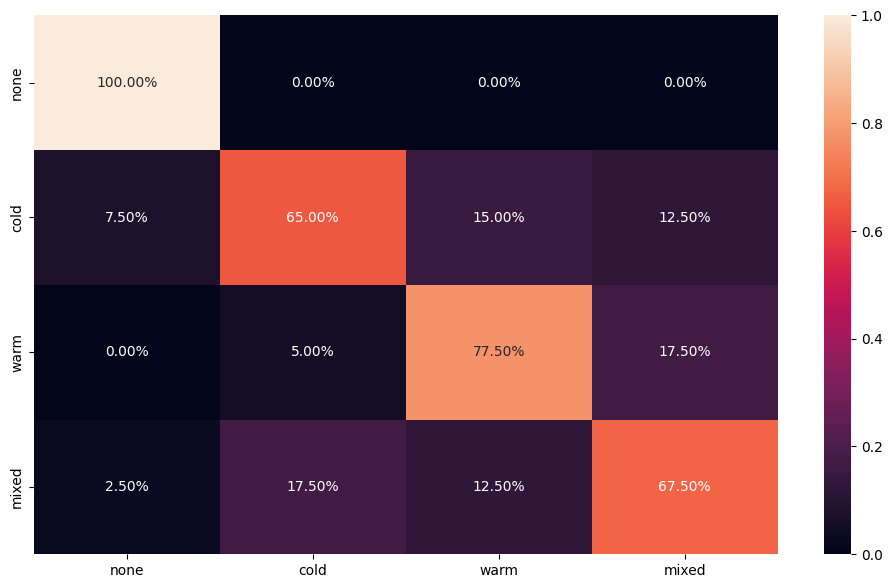

In [ ]:
import copy
import os
from sklearn.metrics import confusion_matrix
import numpy as np
import torch
import torch.nn as nn
import torch.optim.lr_scheduler
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from torch.optim import Adam
import seaborn as sns
import matplotlib.pyplot as plt

# from dataset import ImageClassifierDataset
# from load_images import load_images
# from network import SimpleNet


def save_models(epoch):
    plt.plot(test_accuracies, color='blue')
    plt.show()
    plt.plot([acc[0] for acc in accuracies_by_classes], color='orange', label='none')  # none
    plt.plot([acc[1] for acc in accuracies_by_classes], color='blue', label='cold')  # cold
    plt.plot([acc[2] for acc in accuracies_by_classes], color='red', label='warm')  # warm
    plt.plot([acc[3] for acc in accuracies_by_classes], color='green', label='mixed')  # mixed
    plt.legend(loc="upper left")
    plt.show()
    plt.figure(figsize=(12, 7))
    sns.heatmap(best_confmat / np.sum(best_confmat) * 4, annot=True, fmt='.2%', yticklabels=classes_names,
                xticklabels=classes_names)
    # plt.savefig('{}MODELS/1/output{}.png'.format(my_data_dir, epoch))
    plt.savefig('{}MODELS/1/output.png'.format(my_data_dir, epoch))
    plt.show()
    torch.save(model.state_dict(), "{}MODELS/1/cnn.model".format(my_data_dir))
    print("Improved model saved")


def getNumberOfPhotos(training):
    if training:
        return len(os.listdir(my_data_dir + 'train/COLD')) + len(os.listdir(my_data_dir + 'train/WARM')) + \
               len(os.listdir(my_data_dir + 'train/MIXED')) + len(os.listdir(my_data_dir + 'train/NONE'))
    else:
        return len(os.listdir(my_data_dir + 'test/COLD')) + len(os.listdir(my_data_dir + 'test/WARM')) + \
               len(os.listdir(my_data_dir + 'test/NONE')) + len(os.listdir(my_data_dir + 'test/MIXED'))


accuracies_by_classes = []
classes_names = ['none', 'cold', 'warm', 'mixed']
confmat = confusion_matrix([], [], labels=classes_names)
best_confmat = confusion_matrix([], [], labels=classes_names)


def test():
    global confmat
    model.eval()
    test_acc = 0.0
    labels_for_matrix = []
    predictions = []
    for i, (images, labels) in enumerate(test_loader):
        # Predict classes using images from the test set
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, prediction = torch.max(outputs.data, 1)
        # prediction = prediction.cpu().numpy()
        labels_for_matrix.extend(labels.data.cpu())
        predictions.extend(prediction.cpu())
        test_acc += torch.sum(torch.eq(prediction, labels.data))

    # predictions = predictions.cpu()
    confmat = confusion_matrix(labels_for_matrix, predictions)
    accuracies_by_classes.append(confmat.diagonal() / confmat.sum(axis=1))
    # Compute the average acc and loss over all test images
    test_acc = test_acc / getNumberOfPhotos(False)
    return test_acc


test_accuracies = []
losses = []


def train(num_epochs):
    global best_confmat
    best_acc = 0.0

    for epoch in range(num_epochs):
        print("training...")
        model.train()
        train_acc = 0.0
        train_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            # Clear all accumulated gradients
            optimizer.zero_grad()
            # Predict classes using images from the train set
            # transform = T.ToPILImage()
            # transform(images[0]).show()
            # return
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            # Compute the loss based on the predictions and actual labels
            loss = loss_fn(outputs, labels)
            # Backpropagate the loss
            loss.backward()
            # Adjust parameters according to the computed gradients
            optimizer.step()

            train_loss += loss.cpu().data.item() * images.size(0)
            _, prediction = torch.max(outputs.data, 1)

            train_acc += torch.sum(prediction == labels.data)

        # Call the learning rate adjustment function
        scheduler.step()
        # adjust_learning_rate(epoch)

        # Compute the average acc and loss over all 50000 training images
        number = getNumberOfPhotos(True)
        train_acc = train_acc / number
        train_loss = train_loss / number
        losses.append(train_loss)

        # Evaluate on the test set
        test_acc = test()
        test_accuracies.append(test_acc.cpu())

        # Save the model if the test acc is greater than our current best
        if test_acc >= best_acc:
            best_acc = test_acc
            best_confmat = copy.deepcopy(confmat)
            save_models(epoch)

        # Print the metrics
        print("Epoch {}, Train Accuracy: {} , TrainLoss: {} , Test Accuracy: {}".format(epoch, train_acc, train_loss,
                                                                                        test_acc))




cold_front_train = my_data_dir + 'train/COLD'
warm_front_train =  my_data_dir + 'train/WARM'
mixed_front_train =  my_data_dir + 'train/MIXED'
no_fronts_train =  my_data_dir + 'train/NONE'
cold_front_test =  my_data_dir + 'test/COLD'
warm_front_test =  my_data_dir + 'test/WARM'
mixed_front_test =  my_data_dir + 'test/MIXED'
no_fronts_test =  my_data_dir + 'test/NONE'

batch_size = 8

images, classes = load_images(cold_front_train, warm_front_train, mixed_front_train, no_fronts_train)
train_set = ImageClassifierDataset(images, classes)
# Create a loader for the training set
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)

images, classes = load_images(cold_front_test, warm_front_test, mixed_front_test, no_fronts_test)
test_set = ImageClassifierDataset(images, classes)
# Create a loader for the test set, note that both shuffle is set to false for the test loader
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=2)

# Create model, optimizer and loss function
model = SimpleNet(num_classes=4)
model = model.to(device)
optimizer = Adam(model.parameters(), lr=2e-4, weight_decay=0.0001)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

loss_fn = nn.CrossEntropyLoss()

if __name__ == "__main__":la
    
    train(100)
    plt.plot(test_accuracies, color='blue')
    plt.show()
    # print_confusion_matrix(confmat.png, ['none', 'cold', 'warm', 'mixed'])
    # df_cm = pd.DataFrame(, index=[i for i in classes_names],
    #                      columns=[i for i in classes_names])

    plt.plot([acc[0] for acc in accuracies_by_classes], color='orange', label='none')  # none
    plt.plot([acc[1] for acc in accuracies_by_classes], color='blue', label='cold')  # cold
    plt.plot([acc[2] for acc in accuracies_by_classes], color='red', label='warm')  # warm
    plt.plot([acc[3] for acc in accuracies_by_classes], color='green', label='mixed')  # mixed
    plt.legend(loc="upper left")
    plt.show()

    plt.figure(figsize=(12, 7))
    sns.heatmap(best_confmat/np.sum(best_confmat) * 4, annot=True, fmt='.2%', yticklabels=classes_names,
                xticklabels=classes_names)
    plt.savefig('output.png')


In [ ]:
getNumberOfPhotos(False)

159

In [ ]:
a = SimpleNet()
t = torch.rand(1,1,240,240)
r = a.net(t)
print(r.size())
r = torch.flatten(r,1)
print(r.size())

torch.Size([1, 512, 1, 1])
torch.Size([1, 512])


In [ ]:
print(model)

SimpleNet(
  (unit1): Unit(
    (conv): Conv2d(1, 32, kernel_size=(1, 1), stride=(1, 1))
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (unit2): Unit(
    (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (unit3): Unit(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (unit4): Unit(
    (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (unit6): Unit(
    (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn)